In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix
import torch
import time
import numpy as np
import os

start_time = time.time()

data = pd.read_csv('datasetofsenti.csv')
data = data.drop(columns=["Unnamed: 0"], errors="ignore")

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.375, random_state=42
)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(data["label"].unique()))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    save_total_limit=1,
    fp16=True,
    report_to=[]  # Disable wandb
)

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

train_start_time = time.time()
trainer.train()
train_end_time = time.time()

eval_start_time = time.time()
results = trainer.evaluate()
eval_end_time = time.time()

predictions = trainer.predict(test_dataset)
logits = predictions.predictions
true_labels = test_labels.to_numpy()
predicted_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

if predicted_probs.shape[1] == 2:
    auc_roc = roc_auc_score(true_labels, predicted_probs[:, 1])
else:
    true_labels_one_hot = np.eye(predicted_probs.shape[1])[true_labels]
    auc_roc = roc_auc_score(true_labels_one_hot, predicted_probs, average="weighted", multi_class="ovr")

conf_matrix = confusion_matrix(true_labels, np.argmax(predicted_probs, axis=1))

metrics = {
    "Training Time (s)": train_end_time - train_start_time,
    "Evaluation Time (s)": eval_end_time - eval_start_time,
    "Accuracy": f"{results['eval_accuracy']:.2%}",
    "F1 Score": f"{results['eval_f1']:.4f}",
    "Precision": f"{results['eval_precision']:.4f}",
    "Recall": f"{results['eval_recall']:.4f}",
    "AUC-ROC": f"{auc_roc:.4f}",
    "Confusion Matrix": conf_matrix,
    "Model Size (MB)": os.path.getsize("./results") / (1024 * 1024),
    "Device": device,
    "Total Execution Time (s)": time.time() - start_time
}

for key, value in metrics.items():
    if key == "Confusion Matrix":
        print(f"{key}:\n{value}")
    else:
        print(f"{key}: {value}")


Map:   0%|          | 0/260505 [00:00<?, ? examples/s]

Map:   0%|          | 0/156304 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Shezan\AppData\Local\Temp\ipykernel_12844\2622775292.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.092200,0.097978,0.940782,0.939668,0.944905,0.940782
2,0.106900,0.094273,0.941166,0.942358,0.950760,0.941166
3,0.082300,0.091393,0.941287,0.942120,0.947698,0.941287


Training Time (s): 3930.727368116379
Evaluation Time (s): 132.53545260429382
Accuracy: 94.13%
F1 Score: 0.9421
Precision: 0.9477
Recall: 0.9413
AUC-ROC: 0.9983
Confusion Matrix:
[[43765    28     1   681   819    46]
 [   25 48373  3833    55    18   498]
 [    5     9 12804     1     1     1]
 [  490    49     0 21012    54     0]
 [   35    20     0   932 17064     0]
 [    2     2     0     0  1572  4109]]
Model Size (MB): 0.0
Device: cuda
Total Execution Time (s): 4247.264976024628


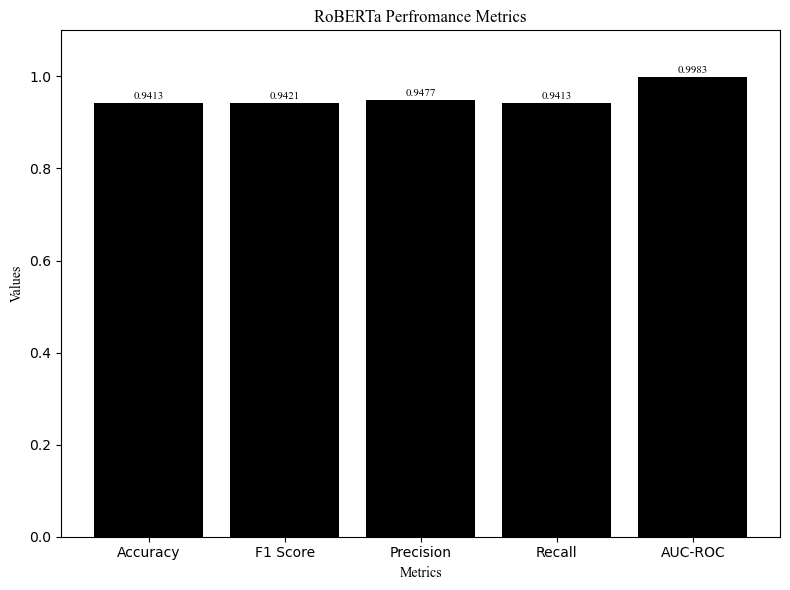

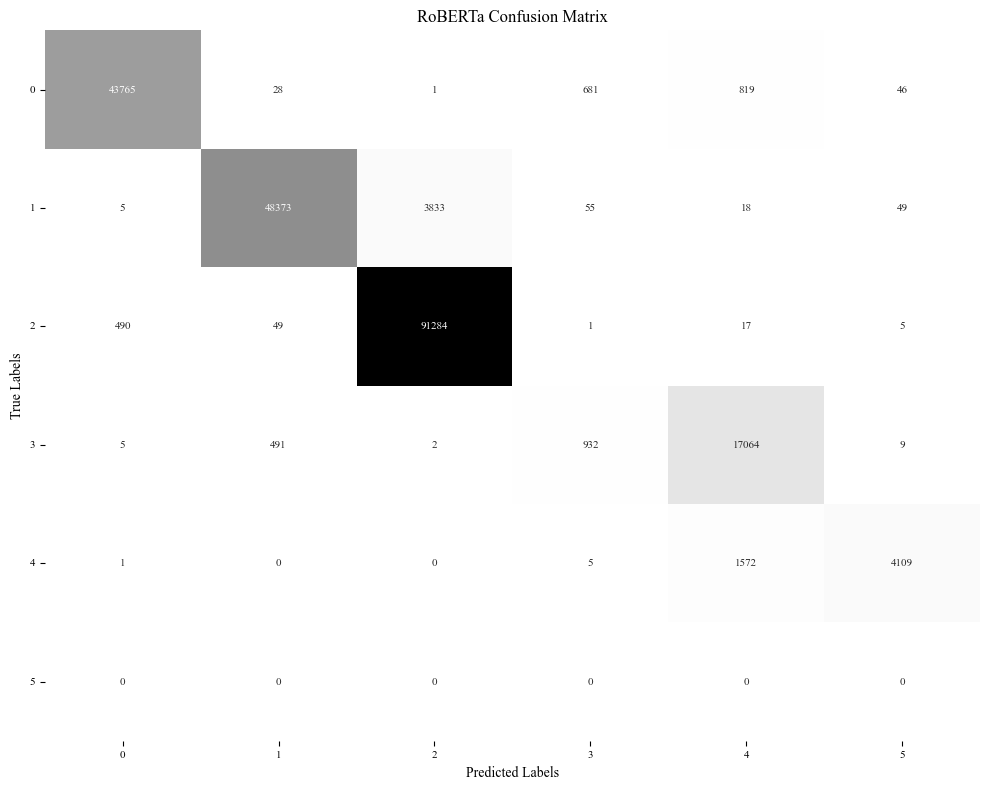

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

metrics = {
    "Accuracy": 94.13 / 100,
    "F1 Score": 0.9421,
    "Precision": 0.9477,
    "Recall": 0.9413,
    "AUC-ROC": 0.9983
}
conf_matrix = np.array([
    [43765, 28, 1, 681, 819, 46],
    [5, 48373, 3833, 55, 18, 49],
    [490, 49, 91284, 1, 17, 5],
    [5, 491, 2, 932, 17064, 9],
    [1, 0, 0, 5, 1572, 4109],
    [0, 0, 0, 0, 0, 0]
])
fig, ax = plt.subplots(figsize=(8, 6))
metrics_names = list(metrics.keys())
metrics_values = list(metrics.values())

bars = ax.bar(metrics_names, metrics_values, color="black")
ax.set_title("RoBERTa Perfromance Metrics", fontsize=12, fontname="Times New Roman")
ax.set_ylabel("Values", fontsize=10, fontname="Times New Roman")
ax.set_xlabel("Metrics", fontsize=10, fontname="Times New Roman")
ax.set_ylim(0, 1.1)

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', fontsize=8, fontname="Times New Roman")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greys", cbar=False,
            annot_kws={"fontsize": 8, "fontname": "Times New Roman"})
plt.title("RoBERTa Confusion Matrix", fontsize=12, fontname="Times New Roman")
plt.xlabel("Predicted Labels", fontsize=10, fontname="Times New Roman")
plt.ylabel("True Labels", fontsize=10, fontname="Times New Roman")
plt.xticks(fontsize=8, fontname="Times New Roman")
plt.yticks(fontsize=8, fontname="Times New Roman", rotation=0)
plt.tight_layout()
plt.show()


In [10]:
import numpy as np
import torch
from sklearn.preprocessing import LabelBinarizer

# Step 1: Get predictions from the Trainer
predictions = trainer.predict(test_dataset)
logits = predictions.predictions  # Raw logits (output from the model)
true_labels = test_labels.to_numpy()  # Convert test labels to numpy array

# Step 2: Convert logits to probabilities
predicted_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

# Step 3: Print or Save the extracted data
print("True Labels:")
print(true_labels)  # Ground truth test labels

print("\nPredicted Probabilities:")
print(predicted_probs)  # Model probabilities for each class

# Step 4: Handle one-hot encoding if required (for multi-class AUC-ROC)
num_classes = predicted_probs.shape[1]  # Number of classes
if num_classes > 2:
    label_binarizer = LabelBinarizer()
    true_labels_one_hot = label_binarizer.fit_transform(true_labels)
    print("\nOne-hot Encoded True Labels:")
    print(true_labels_one_hot)
else:
    true_labels_one_hot = true_labels



True Labels:
[0 0 3 ... 0 0 2]

Predicted Probabilities:
[[9.9985838e-01 1.5872494e-05 2.3320978e-05 5.9902166e-05 2.4108305e-05
  1.8304847e-05]
 [9.9985814e-01 1.5748970e-05 2.3595874e-05 6.0371971e-05 2.4108300e-05
  1.8021050e-05]
 [7.2533090e-05 2.5611136e-05 2.8683113e-05 9.9978238e-01 5.5667388e-05
  3.5143283e-05]
 ...
 [9.9985683e-01 1.5934593e-05 2.3503850e-05 6.3084117e-05 2.3780907e-05
  1.6797445e-05]
 [9.9985862e-01 1.5748978e-05 2.3642015e-05 5.9843711e-05 2.3549843e-05
  1.8629460e-05]
 [6.2216721e-05 1.4593522e-04 9.9968362e-01 3.6611058e-05 3.3992219e-05
  3.7625956e-05]]

One-hot Encoded True Labels:
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 1 0 0]
 ...
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]]


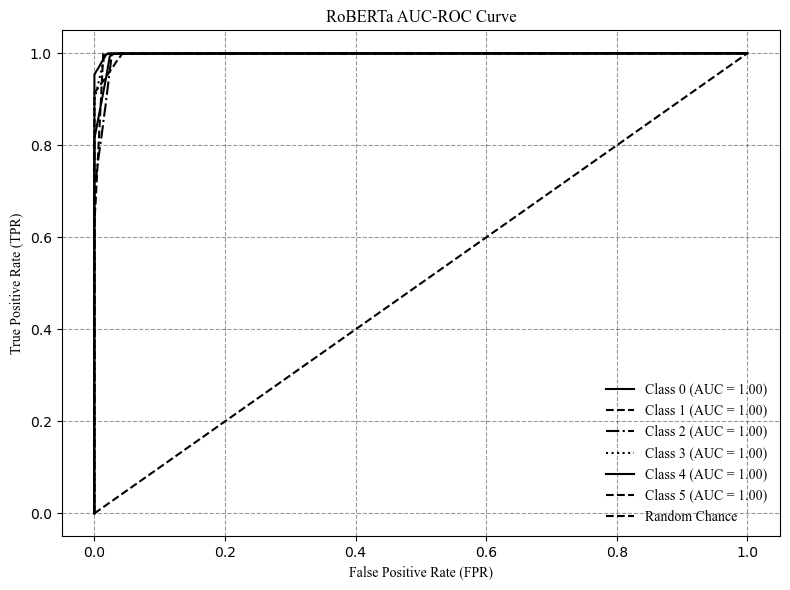

In [18]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

predicted_probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
num_classes = predicted_probs.shape[1]
true_labels_one_hot = np.eye(num_classes)[true_labels]

plt.figure(figsize=(8, 6))
line_styles = ['-', '--', '-.', ':']
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], predicted_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})", linestyle=line_styles[i % len(line_styles)], color='black')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.title("RoBERTa AUC-ROC Curve", fontsize=12, fontname="Times New Roman", color='black')
plt.xlabel("False Positive Rate (FPR)", fontsize=10, fontname="Times New Roman", color='black')
plt.ylabel("True Positive Rate (TPR)", fontsize=10, fontname="Times New Roman", color='black')
plt.legend(loc="lower right", fontsize=8, prop={"family": "Times New Roman"}, frameon=False, facecolor='white', edgecolor='white', handlelength=2)
plt.grid(alpha=0.4, linestyle="--", color='black')
plt.tight_layout()

plt.savefig("auc_roc_curve.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()